In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
fname = "Brathwaite_Batting.xlsx"

In [ ]:
# 1) Read the sheet in raw form (don't assume first row is header)
raw = pd.read_excel(fname, header=None)
print("Raw shape:", raw.shape)
display(raw.head(12))

Raw shape: (44, 15)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,NaN,Span,Mat,Inns,NO,Runs,HS,Ave,BF,SR,100,50,0.0,4s,6s
1,overall,2011-2019,41,27,6,310,37*,14.76,274,113.13,0,0,3.0,13,22
2,NaN,Bat1,Runs,BF,SR,4s,6s,NaN,Opposition,Ground,Start Date,NaN,NaN,NaN,NaN
3,NaN,1,1,2,50,0,0,NaN,v Bangladesh,Mirpur,2011-10-11 00:00:00,T20I # 209,NaN,NaN,NaN
4,NaN,1,1,2,50,0,0,NaN,v South Africa,Durban,2015-01-14 00:00:00,T20I # 415,NaN,NaN,NaN
5,NaN,DNB,-,-,-,-,-,NaN,v England,Wankhede,2016-03-16 00:00:00,T20I # 537,NaN,NaN,NaN
6,NaN,DNB,-,-,-,-,-,NaN,v Sri Lanka,Bengaluru,2016-03-20 00:00:00,T20I # 543,NaN,NaN,NaN
7,NaN,10*,10,10,100,0,1,NaN,v South Africa,Nagpur,2016-03-25 00:00:00,T20I # 549,NaN,NaN,NaN
8,NaN,13,13,8,162.5,0,2,NaN,v Afghanistan,Nagpur,2016-03-27 00:00:00,T20I # 552,NaN,NaN,NaN
9,NaN,DNB,-,-,-,-,-,NaN,v India,Wankhede,2016-03-31 00:00:00,T20I # 556,NaN,NaN,NaN


In [ ]:
# 2) Find the row index that contains a likely header row (look for 'Start' or 'Start Date' or 'Opposition')
header_row = None
for i in range(0, 8):   # check first 8 rows for header
    row_text = " ".join([str(x).lower() for x in raw.iloc[i].fillna("").astype(str)])
    if ("start date" in row_text) or ("opposition" in row_text) or ("match" in row_text and "ground" in row_text):
        header_row = i
        break

if header_row is None:
    # fallback: pick row 1 or 2 if it looks like 'Runs BF SR 4s 6s'
    for i in range(0, 8):
        row_text = " ".join([str(x).lower() for x in raw.iloc[i].fillna("").astype(str)])
        if any(tok in row_text for tok in ["runs", "bf", "sr", "4s", "6s"]):
            header_row = i
            break


In [ ]:
print("Detected header row index:", header_row)

Detected header row index: 2


In [ ]:
# 3) Build a dataframe using the detected header_row
if header_row is None:
    # As last resort, assume header is row 1 (index 1) and data starts after 2 rows
    header_row = 1
    df = pd.read_excel(fname, header=header_row+0)  # try using default reading
else:
    df = pd.read_excel(fname, header=header_row)

print("Inferred columns (raw):", df.columns.tolist())
display(df.head(8))

Inferred columns (raw): ['Unnamed: 0', 'Bat1', 'Runs', 'BF', 'SR', '4s', '6s', 'Unnamed: 7', 'Opposition', 'Ground', 'Start Date', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14']


,Unnamed: 0,Bat1,Runs,BF,SR,4s,6s,Unnamed: 7,Opposition,Ground,Start Date,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14
0,NaN,1,1,2,50,0,0,NaN,v Bangladesh,Mirpur,2011-10-11,T20I # 209,NaN,NaN,NaN
1,NaN,1,1,2,50,0,0,NaN,v South Africa,Durban,2015-01-14,T20I # 415,NaN,NaN,NaN
2,NaN,DNB,-,-,-,-,-,NaN,v England,Wankhede,2016-03-16,T20I # 537,NaN,NaN,NaN
3,NaN,DNB,-,-,-,-,-,NaN,v Sri Lanka,Bengaluru,2016-03-20,T20I # 543,NaN,NaN,NaN
4,NaN,10*,10,10,100,0,1,NaN,v South Africa,Nagpur,2016-03-25,T20I # 549,NaN,NaN,NaN
5,NaN,13,13,8,162.5,0,2,NaN,v Afghanistan,Nagpur,2016-03-27,T20I # 552,NaN,NaN,NaN
6,NaN,DNB,-,-,-,-,-,NaN,v India,Wankhede,2016-03-31,T20I # 556,NaN,NaN,NaN
7,NaN,34*,34,10,340,1,4,NaN,v England,Eden Gardens,2016-04-03,T20I # 557,NaN,NaN,NaN


In [ ]:
# 4) Normalize column names (lowercase, strip)
df.columns = [str(c).strip() for c in df.columns]

In [ ]:
# 5) Map likely column names to canonical names we need
col_map = {}
# candidates for each desired field
candidates = {
    'start_date': ['start date', 'start', 'date', 'start_date'],
    'runs': ['runs', 'score', 'r', 'runs_scored'],
    'bf': ['bf', 'balls', 'balls faced', 'b'],
    'sr': ['sr', 'strike rate', 'strike_rate'],
    '4s': ['4s', 'fours'],
    '6s': ['6s', 'sixes'],
    'opposition': ['opposition', 'opp', 'opposition/team', 'opposition/'],
    'ground': ['ground', 'venue']
}

for canon, keys in candidates.items():
    found = None
    for col in df.columns:
        low = str(col).lower()
        if any(k in low for k in keys):
            found = col
            break
    col_map[canon] = found

print("Column mapping detected:")
for k, v in col_map.items():
    print(f"  {k:10s} <- {v}")

Column mapping detected:
  start_date <- Start Date
  runs       <- Runs
  bf         <- Bat1
  sr         <- SR
  4s         <- 4s
  6s         <- 6s
  opposition <- Opposition
  ground     <- Ground


In [ ]:
# 6) Build cleaned df with only columns we found (if a column wasn't found we'll create it as NaN)
clean = pd.DataFrame()
for canon in ['start_date','runs','bf','sr','4s','6s','opposition','ground']:
    col = col_map.get(canon)
    if col is not None:
        clean[canon] = df[col]
    else:
        clean[canon] = np.nan

In [ ]:
# 7) Convert types and cleanup
# parse dates
clean['start_date'] = pd.to_datetime(clean['start_date'], errors='coerce', dayfirst=True)

In [ ]:
# extract numeric runs (remove stars or non-numeric)
clean['runs'] = pd.to_numeric(clean['runs'].astype(str).str.extract(r'(\d+)', expand=False), errors='coerce')
clean['bf'] = pd.to_numeric(clean['bf'], errors='coerce')
clean['4s'] = pd.to_numeric(clean['4s'], errors='coerce').fillna(0)
clean['6s'] = pd.to_numeric(clean['6s'], errors='coerce').fillna(0)
clean['sr'] = pd.to_numeric(clean['sr'], errors='coerce')


In [ ]:
# 8) Add period flag relative to 2016-04-03
cutoff = pd.Timestamp('2016-04-03')
clean['period'] = np.where(clean['start_date'] < cutoff, 'Pre-2016', 'Post-2016')


In [ ]:
# 9) Basic quality checks and display
print("\nCleaned data preview:")
display(clean.head(10))


Cleaned data preview:


,start_date,runs,bf,sr,4s,6s,opposition,ground,period
0,2011-10-11,1.0,1.0,50.0,0.0,0.0,v Bangladesh,Mirpur,Pre-2016
1,2015-01-14,1.0,1.0,50.0,0.0,0.0,v South Africa,Durban,Pre-2016
2,2016-03-16,NaN,NaN,NaN,0.0,0.0,v England,Wankhede,Pre-2016
3,2016-03-20,NaN,NaN,NaN,0.0,0.0,v Sri Lanka,Bengaluru,Pre-2016
4,2016-03-25,10.0,NaN,100.0,0.0,1.0,v South Africa,Nagpur,Pre-2016
5,2016-03-27,13.0,13.0,162.5,0.0,2.0,v Afghanistan,Nagpur,Pre-2016
6,2016-03-31,NaN,NaN,NaN,0.0,0.0,v India,Wankhede,Pre-2016
7,2016-04-03,34.0,NaN,340.0,1.0,4.0,v England,Eden Gardens,Post-2016
8,2016-08-27,14.0,14.0,140.0,1.0,1.0,v India,Lauderhill,Post-2016
9,2016-08-28,18.0,18.0,180.0,2.0,1.0,v India,Lauderhill,Post-2016


In [ ]:
print("\nCounts by period (rows with a valid date):")
print(clean.dropna(subset=['start_date']).groupby('period').size())


Counts by period (rows with a valid date):
period
Post-2016    34
Pre-2016      7
dtype: int64


In [ ]:
# 10) If runs column exists, show simple stats
if clean['runs'].notna().sum() > 0:
    summary = clean.groupby('period').agg(
        Innings=('runs','count'),
        Avg_Runs=('runs','mean'),
        Median_Runs=('runs','median'),
        Std_Runs=('runs','std'),
        Avg_4s=('4s','mean'),
        Avg_6s=('6s','mean'),
        Avg_BF=('bf','mean')
    ).round(2)
    print("\nSummary (Pre vs Post):")
    display(summary)
else:
    print("\nNo numeric runs found yet. Please check the mapping above.")


Summary (Pre vs Post):


,Innings,Avg_Runs,Median_Runs,Std_Runs,Avg_4s,Avg_6s,Avg_BF
period,,,,,,,
Post-2016,23,12.39,10.0,10.60,0.38,0.56,8.72
Pre-2016,4,6.25,5.5,6.18,0.00,0.43,5.00


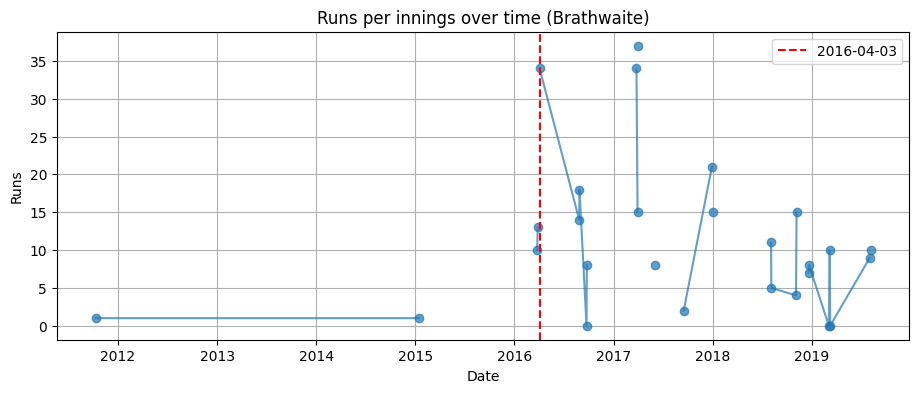

In [ ]:
# 11) Quick time series plot if dates are present
if clean['start_date'].notna().sum() > 0:
    plt.figure(figsize=(11,4))
    plt.plot(clean['start_date'], clean['runs'], marker='o', linestyle='-', alpha=0.7)
    plt.axvline(cutoff, color='red', linestyle='--', label='2016-04-03')
    plt.title('Runs per innings over time (Brathwaite)')
    plt.xlabel('Date')
    plt.ylabel('Runs')
    plt.grid(True)
    plt.legend()
    plt.show()


In [ ]:
# 12) Save cleaned csv for reuse
clean.to_csv("Brathwaite_batting_cleaned.csv", index=False)
print("\nSaved cleaned data to Brathwaite_batting_cleaned.csv in current working directory.")


Saved cleaned data to Brathwaite_batting_cleaned.csv in current working directory.


In [ ]:
# === Analysis: Brathwaite pre/post comparison, z-scores, outliers, t-test ===
from datetime import datetime
import scipy.stats as stats
%matplotlib inline

In [ ]:
# File you saved earlier
fname = "Brathwaite_batting_cleaned.csv"

In [ ]:
# Load cleaned data
df = pd.read_csv(fname, parse_dates=['start_date'], dayfirst=True)

In [ ]:
# Quick check
print("Rows loaded:", len(df))
print(df[['start_date','runs','bf','4s','6s','period']].head())


Rows loaded: 41
   start_date  runs   bf   4s   6s    period
0  2011-10-11   1.0  1.0  0.0  0.0  Pre-2016
1  2015-01-14   1.0  1.0  0.0  0.0  Pre-2016
2  2016-03-16   NaN  NaN  0.0  0.0  Pre-2016
3  2016-03-20   NaN  NaN  0.0  0.0  Pre-2016
4  2016-03-25  10.0  NaN  0.0  1.0  Pre-2016


In [ ]:
# Drop rows with no runs (DNB) for analysis (but keep counts if you want)
df_analysis = df.dropna(subset=['runs']).copy()
df_analysis['runs'] = pd.to_numeric(df_analysis['runs'], errors='coerce')

In [ ]:
# Career stats (overall)
career_mean = df_analysis['runs'].mean()
career_std  = df_analysis['runs'].std(ddof=1)
print(f"\nCareer (Brathwaite) — mean runs per innings = {career_mean:.2f}, std = {career_std:.2f}")


Career (Brathwaite) — mean runs per innings = 11.48, std = 10.22


In [ ]:
# Z-score per innings (how extraordinary each innings is vs his career)
df_analysis['z_run'] = (df_analysis['runs'] - career_mean) / career_std

In [ ]:
# Flag extreme innings (e.g., z >= 2 is a strong outlier)
df_analysis['outlier_z2'] = df_analysis['z_run'] >= 2.0
df_analysis['outlier_z3'] = df_analysis['z_run'] >= 3.0


In [ ]:
print("\nSummary (pre vs post):")
display(summary)



Summary (pre vs post):


,innings,mean_runs,median_runs,std_runs,mean_bf,mean_4s,mean_6s
period,,,,,,,
Post-2016,23,12.391,10.0,10.603,8.722,0.565,0.826
Pre-2016,4,6.250,5.5,6.185,5.000,0.000,0.750


In [ ]:
# Summary by period
summary = df_analysis.groupby('period').agg(
    innings=('runs','count'),
    mean_runs=('runs','mean'),
    median_runs=('runs','median'),
    std_runs=('runs','std'),
    mean_bf=('bf','mean'),
    mean_4s=('4s','mean'),
    mean_6s=('6s','mean')
).round(3)

In [ ]:
# Proportion of outlier innings per period
outlier_summary = df_analysis.groupby('period').agg(
    innings=('runs','count'),
    outlier_z2_count=('outlier_z2','sum'),
    outlier_z3_count=('outlier_z3','sum')
)
outlier_summary['outlier_z2_pct'] = (outlier_summary['outlier_z2_count'] / outlier_summary['innings'] * 100).round(2)
outlier_summary['outlier_z3_pct'] = (outlier_summary['outlier_z3_count'] / outlier_summary['innings'] * 100).round(3)
print("\nOutlier stats (z>=2 and z>=3):")
display(outlier_summary)


Outlier stats (z>=2 and z>=3):


,innings,outlier_z2_count,outlier_z3_count,outlier_z2_pct,outlier_z3_pct
period,,,,,
Post-2016,23,3,0,13.04,0.0
Pre-2016,4,0,0,0.00,0.0


In [ ]:
# Welch t-test (pre vs post mean runs)
pre_runs = df_analysis.loc[df_analysis['period']=='Pre-2016','runs'].dropna()
post_runs = df_analysis.loc[df_analysis['period']=='Post-2016','runs'].dropna()
t_stat, p_value = stats.ttest_ind(pre_runs, post_runs, equal_var=False, nan_policy='omit')
print(f"\nWelch t-test: t = {t_stat:.3f}, p = {p_value:.4f}")
# --- Fixed plotting section ---
# Ensure start_date is proper datetime and drop missing
df_plot = df_analysis.copy()
df_plot = df_plot.dropna(subset=['start_date', 'runs'])
df_plot['start_date'] = pd.to_datetime(df_plot['start_date'], errors='coerce')


Welch t-test: t = -1.616, p = 0.1527


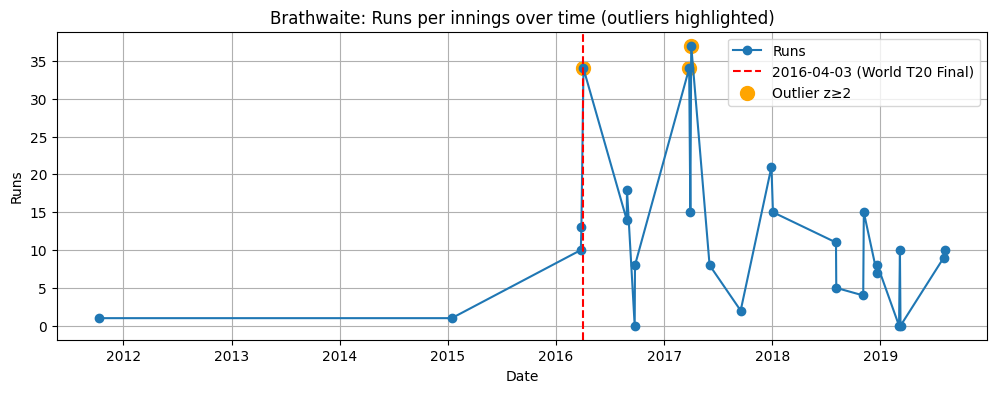

In [ ]:
## Plot runs per innings over time
plt.figure(figsize=(12,4))
plt.plot(df_plot['start_date'], df_plot['runs'], marker='o', linestyle='-', label='Runs')
plt.axvline(pd.Timestamp('2016-04-03'), color='red', linestyle='--', label='2016-04-03 (World T20 Final)')
plt.scatter(df_plot.loc[df_plot['outlier_z2'],'start_date'],
            df_plot.loc[df_plot['outlier_z2'],'runs'],
            color='orange', s=100, label='Outlier z≥2')
plt.title("Brathwaite: Runs per innings over time (outliers highlighted)")
plt.xlabel("Date")
plt.ylabel("Runs")
plt.legend()
plt.grid(True)
plt.show()

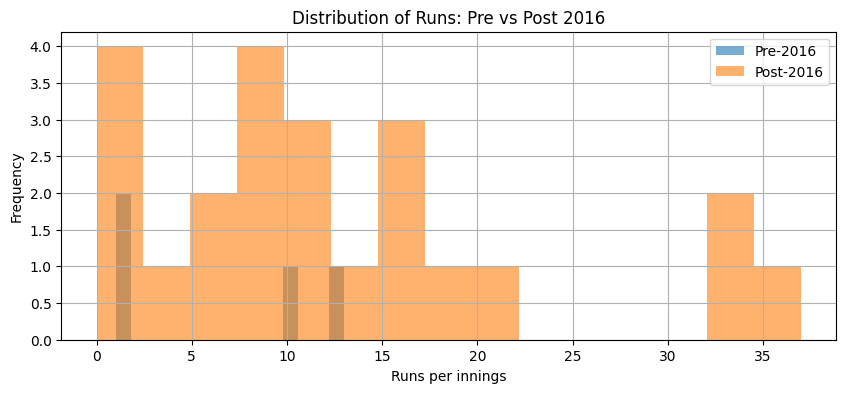

In [ ]:
# Histogram pre vs post
plt.figure(figsize=(10,4))
plt.hist(pre_runs, bins=15, alpha=0.6, label='Pre-2016')
plt.hist(post_runs, bins=15, alpha=0.6, label='Post-2016')
plt.title("Distribution of Runs: Pre vs Post 2016")
plt.xlabel("Runs per innings")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()


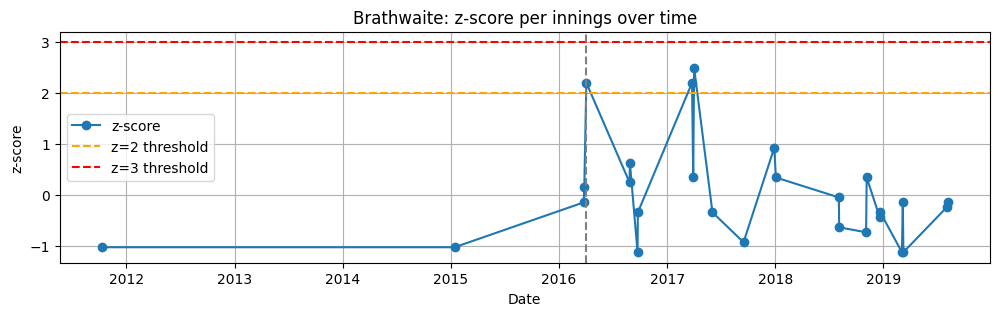

In [ ]:
# Z-score timeline
plt.figure(figsize=(12,3))
plt.plot(df_plot['start_date'], df_plot['z_run'], marker='o', linestyle='-', label='z-score')
plt.axhline(2, color='orange', linestyle='--', label='z=2 threshold')
plt.axhline(3, color='red', linestyle='--', label='z=3 threshold')
plt.axvline(pd.Timestamp('2016-04-03'), color='gray', linestyle='--')
plt.title("Brathwaite: z-score per innings over time")
plt.xlabel("Date")
plt.ylabel("z-score")
plt.legend()
plt.grid(True)
plt.show()